# **Pipeline with Deep Features**

In this notebook, we'll:
1. Load (or extract) deep features from a set of images (Oxford Flowers or any dataset).
2. Train a single KMeans and GMM model (both with 256 clusters/components).
3. Set up a VLAD encoder using the KMeans model.
4. Set up a Fisher Vector encoder using the GMM model.
5. Use each encoder separately for retrieval, then combine them in a pipeline, and compare retrieval metrics.

For more detail, see the paper below.

Reference:
=================
[1]Weixia Zhang, Jia Yan, Wenxuan Shi, Tianpeng Feng, and Dexiang Deng, "Refining Deep Convolutional Features for Improving Fine-Grained Image Recognition," EURASIP Journal on Image and Video Processing, 2017.

In [1]:
from torchvision.models import vgg16, VGG16_Weights

from pyvisim._utils import *
from pyvisim.features import DeepConvFeature
from pyvisim.encoders import VLADEncoder, FisherVectorEncoder, Pipeline, KMeansWeights, GMMWeights
from pyvisim.datasets import OxfordFlowerDataset  # or any dataset you have

## **1. Load Dataset and Extract Deep Features**
We'll load a subset of images and collect their deep descriptors.


In [2]:
train_dataset = OxfordFlowerDataset(
    purpose="train",
)

### Let's define our deep extractor

In [3]:
model = vgg16(weights=VGG16_Weights.DEFAULT)
extractor = DeepConvFeature(
    model=model,
    layer_index=-1,
    spatial_encoding=True,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

2025-01-19 08:46:27,635 - Feature_Extractor - INFO - Selected layer: features.28, Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


## **2. Initialize Encoders: VLAD and Fisher Vector**


In [4]:
vlad_encoder = VLADEncoder(
    feature_extractor=extractor,
    weights=KMeansWeights.OXFORD102_K256_VGG16,
    power_norm_weight=1)

fisher_encoder = FisherVectorEncoder(
    feature_extractor=extractor,
    weights=GMMWeights.OXFORD102_K256_VGG16_PCA,
    power_norm_weight=0.5,
)

## **4. Compute vectors**


### Select images for comparison

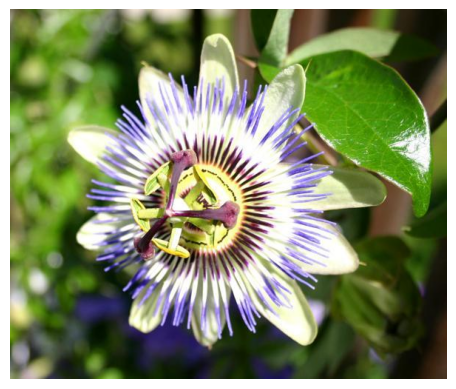

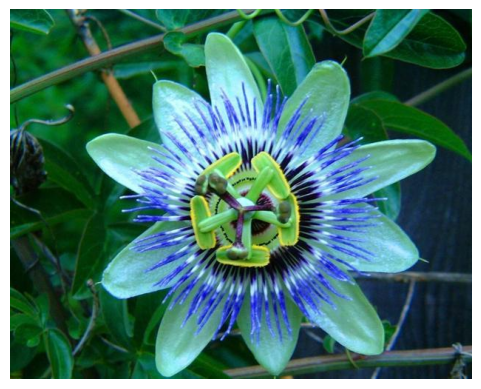

In [5]:
image1, *_ = train_dataset[0]
image2, *_ = train_dataset[1]
plot_image(image1)
plot_image(image2)

### Compute VLAD and Fisher Vectors

In [6]:
fisher_vector_1 = fisher_encoder.encode(image1)
vlad_vector_1 = vlad_encoder.encode(image1)
print(f"Shape of Fisher Vector: {fisher_vector_1.shape}, Shape of VLAD Vector: {vlad_vector_1.shape}")

fisher_vector_2 = fisher_encoder.encode(image2)
vlad_vector_2 = vlad_encoder.encode(image2)

Shape of Fisher Vector: (1, 131840), Shape of VLAD Vector: (1, 131584)


### Compute similarity scores using VLAD and Fisher Vectors

In [7]:
print("Cosine similarity using VLAD:", vlad_encoder.similarity_score(image1, image2))
print("Cosine similarity using Fisher Vectors:", fisher_encoder.similarity_score(image1, image2))

Cosine similarity using VLAD: 0.048457108438014984
Cosine similarity using Fisher Vectors: 0.09541435719894859


## Use a Pipeline

We can combine both steps above by using the pipeline class.

In [8]:
pipeline = Pipeline(
    [vlad_encoder, fisher_encoder])

### Compare images using the pipeline

The result is the similarity score of the concatenated VLAD and Fisher vectors.

In [9]:
sim_score = pipeline.similarity_score(image1, image2)
print("Scores using the pipeline:", sim_score)

Scores using the pipeline: 0.049386886928820865


This is equal to:

In [10]:
combined_vector_1 = np.hstack((vlad_vector_1, fisher_vector_1))
combined_vector_2 = np.hstack((vlad_vector_2, fisher_vector_2))
print("Cosine similarity using concatenated vectors:", cosine_similarity(combined_vector_1, combined_vector_2)) # Cosine similarity was chosen as `similarity_func` for the encoders

Cosine similarity using concatenated vectors: [[0.04938689]]


You can also compare two batches of images at once. The shape is the similarity matrix of size (batch_1_size, batch_2_size).

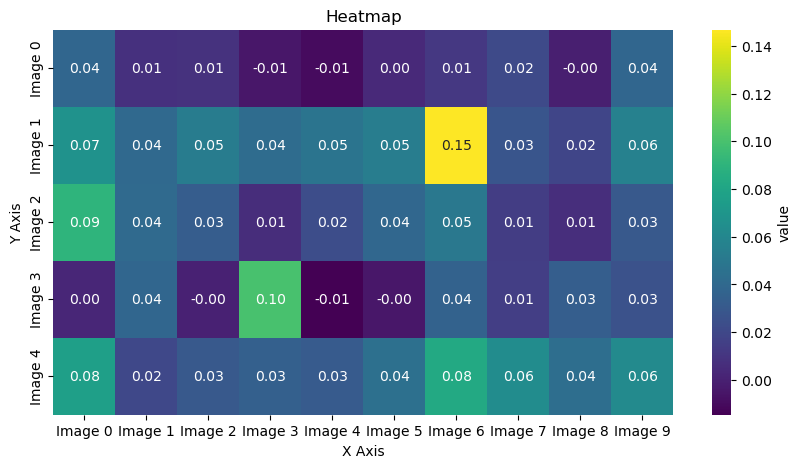

In [11]:
batch_1 = (train_dataset[i][0] for i in range(5))
batch_2 = (train_dataset[i][0] for i in range(5, 15))
similarity_matrix = pipeline.similarity_score(batch_1, batch_2)
plot_and_save_heatmap(similarity_matrix, x_tick_labels=[f"Image {i}" for i in range(10)],
                        y_tick_labels=[f"Image {i}" for i in range(5)],
                      figsize=(10, 5))

You can call the `encode` method, just like with `VLADEncoder` and `FisherVectorEncoder`. Each image is encoded using the encoders in the pipeline, and the end result is the concatenation of the vectors.

In [12]:
images_1_5 = [train_dataset[i][0] for i in range(5)]
encoding = pipeline.encode(images_1_5)
print("Shape of encoded batch:", encoding.shape) # (num_images, dim_vlad + dim_fisher)

Shape of encoded batch: (5, 263424)


### Generate encoding map

The keys will be the image paths and the values are the concatenated VLAD and Fisher vectors.

In [13]:
image_paths = [train_dataset[i][2] for i in range(5)]
encoding_map = pipeline.generate_encoding_map(image_paths)
{os.path.basename(k): v for k, v in encoding_map.items()}

{'image_00001.jpg': array([ 0.        ,  0.        ,  0.        , ..., -0.00184159,
         0.00594611, -0.00185414]),
 'image_00002.jpg': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.23632182e-08,  1.40644207e-08, -1.91887496e-08]),
 'image_00003.jpg': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.66493943e-07,  2.07238863e-07, -3.30692894e-07]),
 'image_00004.jpg': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.76998533e-09, -5.29684887e-09, -6.84943608e-09]),
 'image_00005.jpg': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.09671569e-11, 2.87381254e-11, 2.45213957e-11])}

Print the pipeline to see the encoders it contains.

In [14]:
print(pipeline)

Pipeline(
encoders=[VLADEncoder(feature_extractor=DeepConvFeature, 
similarity_func=cosine_similarity, 
Number of cluster=256, 
Power Norm Weight=1, 
Norm Order=2)
FisherVectorEncoder(feature_extractor=DeepConvFeature, 
similarity_func=cosine_similarity, 
Number of cluster=256, 
Power Norm Weight=0.5, 
Norm Order=2)],
similarity_func=cosine_similarity)
